### Gradient Flow on $TS^2$ ###

Let $(q,v)\in TS^2$ be an element of the tangent bundle of the 2-dimensional sphere, embedded in $\mathbb{R}^3$.

We consider now the dynamical system resulting from the gradient of a given energy function

$$\dot{y} = -\nabla(E(q,v))$$


In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import fsolve
from autograd import grad
import datetime
import integrLie as lie

In [2]:
def spherical2cart(s):
    return np.array([np.cos(s[0])*np.cos(s[1]), np.cos(s[0])*np.sin(s[1]),np.sin(s[0])])

In [3]:
def energy(y):
    return 0.5*np.transpose(y[:3])@D@y[:3] + 0.5*np.transpose(y[3:])@M@y[3:]

myGrad = grad(energy)

def riemannGrad(y):
    gE = myGrad(y)
    E = energy(y)
    u = (np.cross(y[:3], gE[:3]) - np.transpose(y[:3])*gE[3:]*np.cross(y[:3], y[3:])).reshape(3,)
    v = np.cross(y[:3], gE[3:]).reshape(3,)
    return np.hstack([u, v])

def LieEulerStep(y0, y, dt):
    return actionSE3(expSE3(-dt*riemannGrad(y)), y0)

def riemannDist(y, z):
    return 2*np.arcsin(np.linalg.norm(y-z,2)/2)

def expSE3(x):
    u = x[:3]
    v = x[3:]
    theta = np.linalg.norm(u)

    V = expSO3(u, theta)
    T = tanSO3(u, theta)
    return np.concatenate([V, (np.transpose(T)@v).reshape(3,1)], axis=1)

def tanSO3(x, om):
    return np.eye(3)+((np.cos(om)-1)/om**2)*lie.skw(x)+((1-(np.sin(om)/om))/om**2)*(lie.skw(x)@lie.skw(x))
    
def expSO3(x, om):
    return np.eye(3)+(np.sin(om)/om)*lie.skw(x)+((1-np.cos(om))/om**2)*(lie.skw(x)@lie.skw(x))
    
def actionSE3(a, b):
    return np.array([a[:3,:3]@b[:3],a[:3,:3]@b[3:]+np.cross(a[:,-1], a[:3,:3]@b[:3])]).reshape(6,)

def vecfield(x):
    A = riemannGrad(x)
    return np.block([[A[:3], np.zeros((3,))],[A[3:], A[:3]]])

In [4]:
# I1 = np.random.rand(1)
# I3 = np.random.rand(1)
I1 = 0.5
I3 = 15.0
if I1 > I3:
    tmp = np.copy(I3)
    I3 = np.copy(I1)
    I1 = np.copy(tmp)
I2 = np.copy(I1)
diag = np.array([1/I1, 1/I2, 1/I3]).reshape(3,)
D = np.diag(diag)

M = np.eye(3)
# M = np.array([[2, 0, 0],[0, 2, 0],[0, 3, 0]])

h = np.arange(0.1,10.0,0.1)
N = np.size(h)
nTime = 100
time = np.linspace(h[0],h[-1],nTime)
dt = time[1]-time[0]

print(dt)

0.09898989898989899


In [5]:
# dimensions: method, initial condition, coordinate, time step size
YY = np.zeros((5,2,6,N+1))
RD = np.zeros((5,N+1))

# initialization
phi0 = np.zeros((2,))
theta0 = np.zeros((2,))
phi0[0]=-np.pi/2+(np.pi/4)*np.random.rand()
theta0[0]=2*np.pi*np.random.rand()
phi0[1]=phi0[0]
theta0[1]=theta0[0]+0.1*theta0[0]
YY[0,0,:3,0]=spherical2cart([phi0[0],theta0[0]])
YY[0,1,:3,0]=spherical2cart([phi0[1],theta0[1]])
YY[1,:,:3,0]=np.copy(YY[0,:,:3,0])
YY[2,:,:3,0]=np.copy(YY[0,:,:3,0])
YY[3,:,:3,0]=np.copy(YY[0,:,:3,0])
YY[4,:,:3,0]=np.copy(YY[0,:,:3,0])
# v0 = np.random.rand(2,3)
# v0[0,:] = np.cross(YY[0,0,:3,0],v0[0,:])
# v0[1,:] = np.cross(YY[0,1,:3,0],v0[1,:])
v0 = np.zeros((2,3))
YY[0,:,3:,0]=np.copy(v0)
YY[1,:,3:,0]=np.copy(v0)
YY[2,:,3:,0]=np.copy(v0)
YY[3,:,3:,0]=np.copy(v0)
YY[4,:,3:,0]=np.copy(v0)
RD[0,0] = riemannDist(YY[0,0,:3,0],YY[0,1,:3,0])
RD[1,0] = np.copy(RD[0,0])
RD[2,0] = np.copy(RD[0,0])
RD[3,0] = np.copy(RD[0,0])
RD[4,0] = np.copy(RD[0,0])

my_fun = lambda x, x0, dt : - x + LieEulerStep(x0, x, dt)


In [9]:
now = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')

tmpExact = np.zeros((2,6,nTime+1))
tmpExact[0,:,0] = np.copy(YY[0,0,:,0])
tmpExact[1,:,0] = np.copy(YY[0,1,:,0])
for cnt in range(nTime):
    for j in range(2):
        tmpExact[j,:,cnt+1] = fsolve(my_fun, tmpExact[j,:,cnt], args=(tmpExact[j,:,cnt], dt))

for k in range(N):
    for j in range(2):
        YY[1,j,:,k+1] = LieEulerStep(YY[1,j,:,0],YY[1,j,:,0],h[k])
        # YY[2,j,:,k+1] = fsolve(my_fun, YY[2,j,:,k], args=(YY[2,j,:,0], h[k]))
        YY[2,j,:,k+1] = lie.implieeul(lambda x: -riemannGrad(x), YY[2,j,:,k], YY[2,j,:,0], h[k])
        YY[3,j,:,k+1] = lie.impliemidp(lambda x: -riemannGrad(x), YY[3,j,:,k], YY[3,j,:,0], h[k])
        YY[4,j,:,k+1] = lie.implietrap(lambda x: -riemannGrad(x), YY[4,j,:,k], YY[4,j,:,0], h[k])
        YY[0,j,:,k+1] = tmpExact[j,:,(k+1)*(nTime//(N+1))]
    RD[0,k+1] = riemannDist(YY[0,0,:3,k+1],YY[0,1,:3,k+1])
    RD[1,k+1] = riemannDist(YY[1,0,:3,k+1],YY[1,1,:3,k+1])
    RD[2,k+1] = riemannDist(YY[2,0,:3,k+1],YY[2,1,:3,k+1])
    RD[3,k+1] = riemannDist(YY[3,0,:3,k+1],YY[3,1,:3,k+1])
    RD[4,k+1] = riemannDist(YY[4,0,:3,k+1],YY[4,1,:3,k+1])


np.save('../out/'+now+'_TS2_sols',YY)
np.save('../out/'+now+'_TS2_dist',RD)
np.save('../out/'+now+'_TS2_matD',D)
np.save('../out/'+now+'_TS2_matM',M)

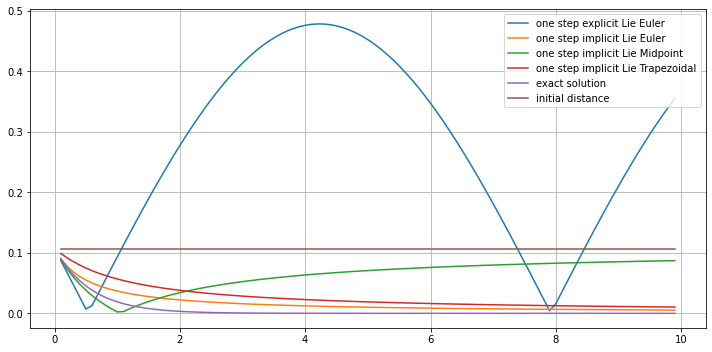

In [10]:
fig1 = plt.figure()
plt.plot(h, RD[1,1:], label='one step explicit Lie Euler')
plt.plot(h, RD[2,1:], label='one step implicit Lie Euler')
plt.plot(h, RD[3,1:], label='one step implicit Lie Midpoint')
plt.plot(h, RD[4,1:], label='one step implicit Lie Trapezoidal')
plt.plot(h, RD[0,1:], label='exact solution')
plt.plot(h, RD[0,0]*np.ones((N, )), label='initial distance')
plt.legend()
plt.grid()

plt.show()

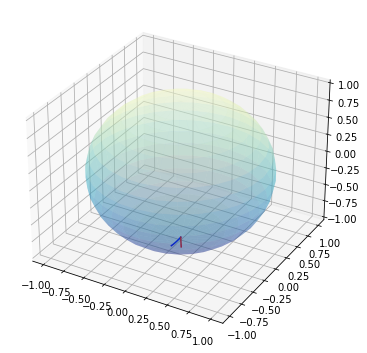

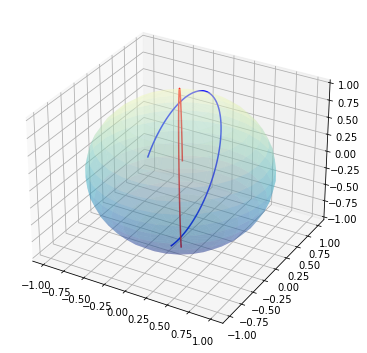

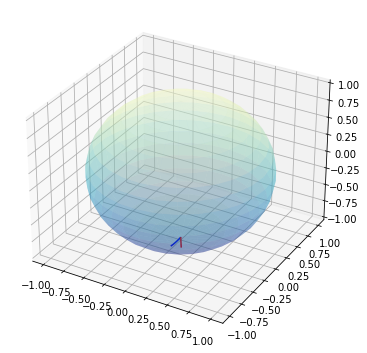

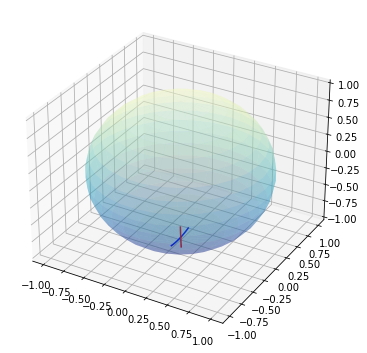

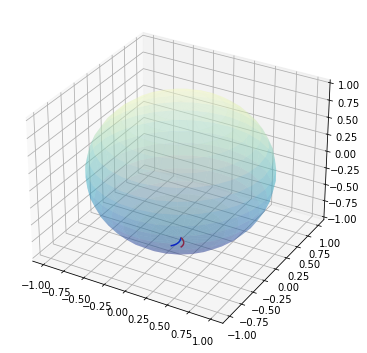

In [11]:
import numpy
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(YY[0,0,0,:],YY[0,0,1,:],YY[0,0,2,:],'blue')
ax.plot(YY[0,1,0,:],YY[0,1,1,:],YY[0,1,2,:],'red')

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(YY[1,0,0,:],YY[1,0,1,:],YY[1,0,2,:],'blue')
ax.plot(YY[1,1,0,:],YY[1,1,1,:],YY[1,1,2,:],'red')

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(YY[2,0,0,:],YY[2,0,1,:],YY[2,0,2,:],'blue')
ax.plot(YY[2,1,0,:],YY[2,1,1,:],YY[2,1,2,:],'red')

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(YY[3,0,0,:],YY[3,0,1,:],YY[3,0,2,:],'blue')
ax.plot(YY[3,1,0,:],YY[3,1,1,:],YY[3,1,2,:],'red')

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
u, v = numpy.mgrid[0: 2 * np.pi: 30j, 0: np.pi: 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap = plt.cm.YlGnBu_r,alpha=0.3)

ax.plot(YY[4,0,0,:],YY[4,0,1,:],YY[4,0,2,:],'blue')
ax.plot(YY[4,1,0,:],YY[4,1,1,:],YY[4,1,2,:],'red')
plt.show()